Mounting and importing packages.
Make sure the path is set up correctly

In [ ]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/gdrive/AmericanSignVAE/')

%cd /content/drive/My Drive/AmericanSignVAE/

%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/AmericanSignVAE
 Conv_VAE.py                                       results/
'Copy of how-to-segment-anything-with-sam.ipynb'   RGB_ASL/
 cVAE-example.ipynb                                RunInColab.ipynb
 cVAE-RGB_Dataset.ipynb                            runs/
 Data/                                             SAM_masks.ipynb
 loader.py                                         sam_vit_h_4b8939.pth
 main.py                                           sam_vit_h_4b8939.pth.1
 model/                                            sam_vit_h_4b8939.pth.3
 model.pt                                          test.py
 model.py                                          train.py
 New_data/                                         utils.py
 Notebook/                                         weights/
 __pycache__/


In [ ]:
import pandas as pd
from torch.utils.data import Dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm

Hyperparameters

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
s_img=100 # image_size
plt.rcParams['figure.dpi'] = 150
####### IMPORTANT ######
# set this flag to true if you want to load the model beforehand
load = False
# specify which model you want to load
model_name = None

latent_space = 128
batch_size=128

Custom data loader

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.data = pd.read_csv(img_dir)
        self.img_labels = self.data.loc[:, "label"]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        bools = [True for x in range(len(self.data.columns))]
        bools[0] = False
        # print(self.data.loc[idx, bools].to_numpy().reshape(28,28))
        image = self.data.loc[idx, bools].to_numpy().reshape(28, 28).astype('float32')
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Train loop function


In [ ]:
def train_vae(train_loader, net, optimizer, device=device):
    """
    Trains variational autoencoder network for one epoch in batches.
    Args:
        train_loader: Data loader for training set.
        net: Neural network model.
        optimizer: Optimizer (e.g. SGD).
        device: whether the network runs on cpu or gpu
    """
    avg_loss = 0

    # iterate through batches
    print(f"\ntype is {type(train_loader)}")
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #print(inputs.shape)
        # convert the inputs to run on GPU if set
        inputs = inputs.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs, sr = net(inputs)
        loss = ((inputs - outputs) ** 2).sum() + net.encoder.kl * 0.5 + (inputs - sr).abs().sum()
        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        avg_loss += loss / len(labels)
    return avg_loss / len(train_loader)

Test loop functions

In [ ]:
def test(epoch, model, loader):
    model.eval()
    test_losses = []
    with torch.no_grad():
        for i, data in enumerate(loader):
            #data = data.transpose(0,1)
            inputs, labels = data
            inputs = inputs.to(device)
            #inputs = inputs.unsqueeze(dim=0).transpose(0, 1)
            recon_batch, sr = model(inputs)
            test_loss = ((inputs - recon_batch) ** 2).sum() + model.encoder.kl * 0.5 + (inputs - sr).abs().sum()
            test_losses.append(test_loss.item() / len(labels))
            if i == 0:
                n = min(inputs.size(0), 8)
                comparison = torch.cat([inputs[:n],
                                        recon_batch.view(len(labels), 1, 100, 100)[:n]])
                save_image(comparison.cpu(),
                           './results/reconstruction/' + str(epoch) + '.png', nrow=n)
    return np.mean(test_losses)

The VAE model, the decoder:

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_space):
        super(Decoder, self).__init__()
        # Sampling vector
        # increase final feature map size
        # less layers, bigger kernels?
        self.fc3 = nn.Linear(latent_space, latent_space)
        self.fc_bn3 = nn.BatchNorm1d(latent_space)
        self.fc4 = nn.Linear(latent_space, 25 * 25 * 128)
        self.fc_bn4 = nn.BatchNorm1d(25 * 25 * 128)
        self.conv5 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU()


    def forward(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 128, 25, 25)
        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        z = self.conv8(conv7).view(-1, 1, 100, 100)
        return z




A utility residual block class

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, kernel_size):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size, padding=1)
        self.bn    = nn.BatchNorm2d(input_channels)
        self.relu  = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.bn(y)
        y = self.relu(y)

        return y + x

A super resolution layer, as descirbed in the "Multi-Stage Variational Auto-Encoders for Coarse-to-Fine Image Generation" paper

In [ ]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=2, padding_mode='replicate')

        self.res1  = ResidualBlock(64, 3)
        self.res2  = ResidualBlock(64, 3)
        self.res3  = ResidualBlock(64, 3)
        self.res4  = ResidualBlock(64, 3)
        self.res5  = ResidualBlock(64, 3)

        self.conv_int = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.tanh     = nn.Tanh()

        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2, padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2, padding_mode='replicate')

    def forward(self, x):

        x = self.conv1(x)
        # chaining the residuals
        y = self.res1(x)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)

        y = self.conv_int(y)
        y = y + x

        y = self.conv2(y)
        y = self.conv3(y)

        y = self.tanh(y)
        return y

Encoder class of the VAE

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_space):
        super(Encoder, self).__init__()
        # tune parameters?
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(25 * 25 *  128, latent_space)
        self.fc_bn1 = nn.BatchNorm1d(latent_space)
        self.fc21 = nn.Linear(latent_space, latent_space)
        self.fc22 = nn.Linear(latent_space, latent_space)

        # Sampling vector
        self.fc3 = nn.Linear(latent_space,latent_space)
        self.fc_bn3 = nn.BatchNorm1d(latent_space)
        self.fc4 = nn.Linear(latent_space, 25 * 25 * 128)
        self.fc_bn4 = nn.BatchNorm1d(25 * 25 * 128)

        # Non-linearity
        self.relu = nn.ReLU()

        # Normal distribution
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(try_gpu())  # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(try_gpu())
        self.kl = 0
    def kull_leib(self, mu, sigma):
        res = (sigma ** 2 + mu ** 2 - torch.log(sigma) - 1 / 2).sum()
        return res
    def reparameterize(self, mu, sig):
        return mu + sig * self.N.sample(mu.shape)
    def forward(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, 25 * 25 * 128)
        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))
        mu = self.fc21(fc1)
        sig = self.fc22(fc1).exp()
        # reparameterize to find z
        z = self.reparameterize(mu, sig)
        # loss between N(0,I) and learned distribution
        self.kl = self.kull_leib(mu, sig)
        return z

The Convolutional VAE

In [ ]:
class ConvVarAutoencoder(nn.Module):
    def __init__(self, latent_space=2048):
        super(ConvVarAutoencoder, self).__init__()

        # Encoder
        self.encoder = Encoder(latent_space)
        # Decoder
        self.decoder = Decoder(latent_space)
        self.sr = SRCNN()
    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        w = self.sr(y)
        return y, w

Utilities functions:

In [ ]:
def try_gpu():
    """
    If GPU is available, return torch.device as cuda:0; else return torch.device
    as cpu.
    """
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

Plot latent space

In [ ]:
def plot_latent(model, data_loader, num_batches=100, device=device):
    '''
    Plots position of data in latent space (which is either 2D or 3D)
    Args:
      autoencoder: pytorch network that contains an encoder subnetwork
      data_loader: the data we want to plot in latent space
      num_batches: number of batches to use in for the plot
    '''
    # Iterate over all data
    plt.rcParams['figure.figsize'] = (5, 3)
    plt.rcParams['figure.dpi'] = 144
    for idx, data in enumerate(data_loader):
        x, y = data
        z = model.encoder(x.to(device))
        # Encode image data
        z = z.to('cpu').detach().numpy()  # Get numpy version of data in latent space

        # 2D latent space (single image)
        if np.size(z, axis=1) == 2:
            plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')  # Add data to plot

        # ------------------------------------------------------------------------
        # 3D latent space (4 images: 3D image, and 3 x 2D projections onto xy, xz
        # and yz)
        if np.size(z, axis=1) == 3:
            if idx == 0:  # initialize at first iteration
                plt.rcParams['figure.figsize'] = (5, 5)
                fig1 = plt.figure()
                plt.rcParams['figure.figsize'] = (15, 5)
                fig2 = plt.figure()
                ax1 = fig1.add_subplot(1, 1, 1, projection='3d')
                ax2 = fig2.add_subplot(1, 3, 1)
                ax3 = fig2.add_subplot(1, 3, 2)
                ax4 = fig2.add_subplot(1, 3, 3)
                ax1.grid(False)
                # Hide axes ticks
                ax1.set_xticks([])
                ax1.set_yticks([])
                ax1.set_zticks([])
                # set labels
                ax1.set_xlabel('dimension 1')
                ax1.set_ylabel('dimension 2')
                ax1.set_zlabel('dimension 3')
                ax2.set_xlabel('dimension 1')
                ax2.set_ylabel('dimension 2')
                ax3.set_xlabel('dimension 1')
                ax3.set_ylabel('dimension 3')
                ax4.set_xlabel('dimension 2')
                ax4.set_ylabel('dimension 3')
            ax1.scatter3D(z[:, 0], z[:, 1], z[:, 2], c=y, cmap='tab10');
            ax2.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10');
            ax3.scatter(z[:, 0], z[:, 2], c=y, cmap='tab10');
            ax4.scatter(z[:, 1], z[:, 2], c=y, cmap='tab10');
            if idx > num_batches:
                fig1.tight_layout()
                fig2.tight_layout()

        # Stop if we've reach the maximum number of batches
        if idx > num_batches:
            if np.size(z, axis=1) == 2:
                plt.colorbar()
            break

The former main.py. Data normalization:

In [ ]:
# normalize = transforms.Lambda(lambda x : x / 255.0)
normalize = transforms.Normalize(160, 50)
transform = transforms.Compose([
    transforms.ToTensor(),# replace with to pil image?
    transforms.Resize(100),
    normalize
])
train_data = CustomImageDataset('./Data/sign_mnist_train.csv', transform=transform)
train_data_raw = CustomImageDataset('./Data/sign_mnist_train.csv', transform=transforms.ToTensor())
test_data = CustomImageDataset('./Data/sign_mnist_test.csv', transform=transform)

Load data

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

Load the model

In [ ]:
model = ConvVarAutoencoder(latent_space).to(device)
if (load):
    model.load_state_dict(torch.load(model_name, map_location=device))

criterion = F.mse_loss
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.1)

Training the model

In [ ]:
epochs = 40
train_losses = []
test_losses = []
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train_vae(train_loader, model, optimizer, device)
    test_loss = test(epoch, model, test_loader)
    print('====> Average Training loss per image: {:.4f}'.format(train_loss.item()))
    print('====>Average  Test set loss per image : {:.4f}'.format(test_loss))
    if epoch % 5 == 0:
        torch.save(model.state_dict(), "./model/model" + str(epoch) + ".pt")
        with torch.no_grad():
            sample = torch.randn(batch_size, latent_space).to(device)
            sample = model.decoder(sample).cpu()
            save_image(sample.view(batch_size, 1, 100, 100),
                       './results/' + str(epoch) + '.png')
    train_losses.append(train_loss.cpu().detach().numpy())
    test_losses.append(test_loss)


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


type is <class 'torch.utils.data.dataloader.DataLoader'>
====> Average Training loss per image: 9567.8877
====>Average  Test set loss per image : 5359.1867


  2%|▎         | 1/40 [02:52<1:51:52, 172.12s/it]

type is <class 'torch.utils.data.dataloader.DataLoader'>


  5%|▌         | 2/40 [05:36<1:45:56, 167.28s/it]

====> Average Training loss per image: 4834.7739
====>Average  Test set loss per image : 4365.1256
type is <class 'torch.utils.data.dataloader.DataLoader'>


  8%|▊         | 3/40 [08:19<1:42:08, 165.62s/it]

====> Average Training loss per image: 3407.7717
====>Average  Test set loss per image : 4217.0138
type is <class 'torch.utils.data.dataloader.DataLoader'>


 10%|█         | 4/40 [11:03<1:38:55, 164.87s/it]

====> Average Training loss per image: 2966.6714
====>Average  Test set loss per image : 4251.0105
type is <class 'torch.utils.data.dataloader.DataLoader'>


 12%|█▎        | 5/40 [13:47<1:36:05, 164.73s/it]

====> Average Training loss per image: 2686.7515
====>Average  Test set loss per image : 4359.6233
type is <class 'torch.utils.data.dataloader.DataLoader'>
====> Average Training loss per image: 2527.2151
====>Average  Test set loss per image : 3917.9811


 15%|█▌        | 6/40 [16:32<1:33:19, 164.69s/it]

type is <class 'torch.utils.data.dataloader.DataLoader'>


 18%|█▊        | 7/40 [19:16<1:30:22, 164.31s/it]

====> Average Training loss per image: 2431.9893
====>Average  Test set loss per image : 3824.1165
type is <class 'torch.utils.data.dataloader.DataLoader'>


 20%|██        | 8/40 [22:00<1:27:35, 164.23s/it]

====> Average Training loss per image: 2334.0425
====>Average  Test set loss per image : 3809.4882
type is <class 'torch.utils.data.dataloader.DataLoader'>


 22%|██▎       | 9/40 [24:43<1:24:45, 164.04s/it]

====> Average Training loss per image: 2281.3840
====>Average  Test set loss per image : 3836.5434
type is <class 'torch.utils.data.dataloader.DataLoader'>


 25%|██▌       | 10/40 [27:27<1:21:57, 163.90s/it]

====> Average Training loss per image: 2226.1357
====>Average  Test set loss per image : 3810.3519
type is <class 'torch.utils.data.dataloader.DataLoader'>
====> Average Training loss per image: 2195.7397
====>Average  Test set loss per image : 3800.2868


 28%|██▊       | 11/40 [30:12<1:19:21, 164.21s/it]

type is <class 'torch.utils.data.dataloader.DataLoader'>


 30%|███       | 12/40 [32:55<1:16:33, 164.07s/it]

====> Average Training loss per image: 2162.3940
====>Average  Test set loss per image : 3776.0786
type is <class 'torch.utils.data.dataloader.DataLoader'>


 32%|███▎      | 13/40 [35:39<1:13:45, 163.92s/it]

====> Average Training loss per image: 2134.5112
====>Average  Test set loss per image : 3890.3919
type is <class 'torch.utils.data.dataloader.DataLoader'>


 35%|███▌      | 14/40 [38:23<1:11:04, 164.03s/it]

====> Average Training loss per image: 2119.5168
====>Average  Test set loss per image : 3859.1612
type is <class 'torch.utils.data.dataloader.DataLoader'>


 38%|███▊      | 15/40 [41:07<1:08:19, 163.99s/it]

====> Average Training loss per image: 2087.0403
====>Average  Test set loss per image : 3763.9628
type is <class 'torch.utils.data.dataloader.DataLoader'>
====> Average Training loss per image: 2097.5608
====>Average  Test set loss per image : 3859.2607


 40%|████      | 16/40 [43:52<1:05:38, 164.11s/it]

type is <class 'torch.utils.data.dataloader.DataLoader'>


 42%|████▎     | 17/40 [46:35<1:02:50, 163.91s/it]

====> Average Training loss per image: 2080.0308
====>Average  Test set loss per image : 3810.1552
type is <class 'torch.utils.data.dataloader.DataLoader'>


 45%|████▌     | 18/40 [49:19<1:00:04, 163.83s/it]

====> Average Training loss per image: 2037.6721
====>Average  Test set loss per image : 3826.6499
type is <class 'torch.utils.data.dataloader.DataLoader'>


 48%|████▊     | 19/40 [52:03<57:20, 163.83s/it]  

====> Average Training loss per image: 2022.8115
====>Average  Test set loss per image : 3801.0904
type is <class 'torch.utils.data.dataloader.DataLoader'>


 50%|█████     | 20/40 [54:46<54:34, 163.73s/it]

====> Average Training loss per image: 2051.9158
====>Average  Test set loss per image : 3783.9316
type is <class 'torch.utils.data.dataloader.DataLoader'>
====> Average Training loss per image: 2017.2828
====>Average  Test set loss per image : 3795.0246


 52%|█████▎    | 21/40 [57:31<51:56, 164.03s/it]

type is <class 'torch.utils.data.dataloader.DataLoader'>


 55%|█████▌    | 22/40 [1:00:14<49:10, 163.93s/it]

====> Average Training loss per image: 2000.5498
====>Average  Test set loss per image : 3781.0137
type is <class 'torch.utils.data.dataloader.DataLoader'>


 57%|█████▊    | 23/40 [1:02:58<46:26, 163.90s/it]

====> Average Training loss per image: 1986.6473
====>Average  Test set loss per image : 3842.7774
type is <class 'torch.utils.data.dataloader.DataLoader'>


 60%|██████    | 24/40 [1:05:42<43:41, 163.86s/it]

====> Average Training loss per image: 1978.3406
====>Average  Test set loss per image : 3793.3404
type is <class 'torch.utils.data.dataloader.DataLoader'>


 62%|██████▎   | 25/40 [1:08:26<40:57, 163.83s/it]

====> Average Training loss per image: 1974.8529
====>Average  Test set loss per image : 3781.4781
type is <class 'torch.utils.data.dataloader.DataLoader'>
====> Average Training loss per image: 1968.3704
====>Average  Test set loss per image : 3792.9140


 65%|██████▌   | 26/40 [1:11:10<38:15, 163.94s/it]

type is <class 'torch.utils.data.dataloader.DataLoader'>


 68%|██████▊   | 27/40 [1:13:54<35:29, 163.82s/it]

====> Average Training loss per image: 1953.2765
====>Average  Test set loss per image : 3760.2359
type is <class 'torch.utils.data.dataloader.DataLoader'>


 70%|███████   | 28/40 [1:16:37<32:45, 163.77s/it]

====> Average Training loss per image: 1950.9543
====>Average  Test set loss per image : 3756.0245
type is <class 'torch.utils.data.dataloader.DataLoader'>


 72%|███████▎  | 29/40 [1:19:21<30:01, 163.73s/it]

====> Average Training loss per image: 1940.1541
====>Average  Test set loss per image : 3752.9103
type is <class 'torch.utils.data.dataloader.DataLoader'>


 75%|███████▌  | 30/40 [1:22:05<27:18, 163.89s/it]

====> Average Training loss per image: 1934.1851
====>Average  Test set loss per image : 3751.4151
type is <class 'torch.utils.data.dataloader.DataLoader'>
====> Average Training loss per image: 1925.5006
====>Average  Test set loss per image : 3740.6460


 78%|███████▊  | 31/40 [1:24:50<24:38, 164.26s/it]

type is <class 'torch.utils.data.dataloader.DataLoader'>


 80%|████████  | 32/40 [1:27:34<21:52, 164.10s/it]

====> Average Training loss per image: 1928.2076
====>Average  Test set loss per image : 3753.5605
type is <class 'torch.utils.data.dataloader.DataLoader'>


 82%|████████▎ | 33/40 [1:30:17<19:07, 163.86s/it]

====> Average Training loss per image: 1901.3435
====>Average  Test set loss per image : 3769.1989
type is <class 'torch.utils.data.dataloader.DataLoader'>


 85%|████████▌ | 34/40 [1:33:01<16:22, 163.72s/it]

====> Average Training loss per image: 1916.9315
====>Average  Test set loss per image : 3753.9828
type is <class 'torch.utils.data.dataloader.DataLoader'>


 88%|████████▊ | 35/40 [1:35:44<13:38, 163.71s/it]

====> Average Training loss per image: 1889.8595
====>Average  Test set loss per image : 3801.3572
type is <class 'torch.utils.data.dataloader.DataLoader'>
====> Average Training loss per image: 1924.1115
====>Average  Test set loss per image : 3727.0291


 90%|█████████ | 36/40 [1:38:28<10:55, 163.76s/it]

type is <class 'torch.utils.data.dataloader.DataLoader'>


 92%|█████████▎| 37/40 [1:41:11<08:10, 163.61s/it]

====> Average Training loss per image: 1894.2438
====>Average  Test set loss per image : 3763.3226
type is <class 'torch.utils.data.dataloader.DataLoader'>


 95%|█████████▌| 38/40 [1:43:55<05:27, 163.56s/it]

====> Average Training loss per image: 1884.2014
====>Average  Test set loss per image : 3726.8901
type is <class 'torch.utils.data.dataloader.DataLoader'>


 98%|█████████▊| 39/40 [1:46:38<02:43, 163.57s/it]

====> Average Training loss per image: 1871.7292
====>Average  Test set loss per image : 3768.3984
type is <class 'torch.utils.data.dataloader.DataLoader'>


100%|██████████| 40/40 [1:49:22<00:00, 164.05s/it]

====> Average Training loss per image: 1869.8340
====>Average  Test set loss per image : 3783.0419


Plotting routines

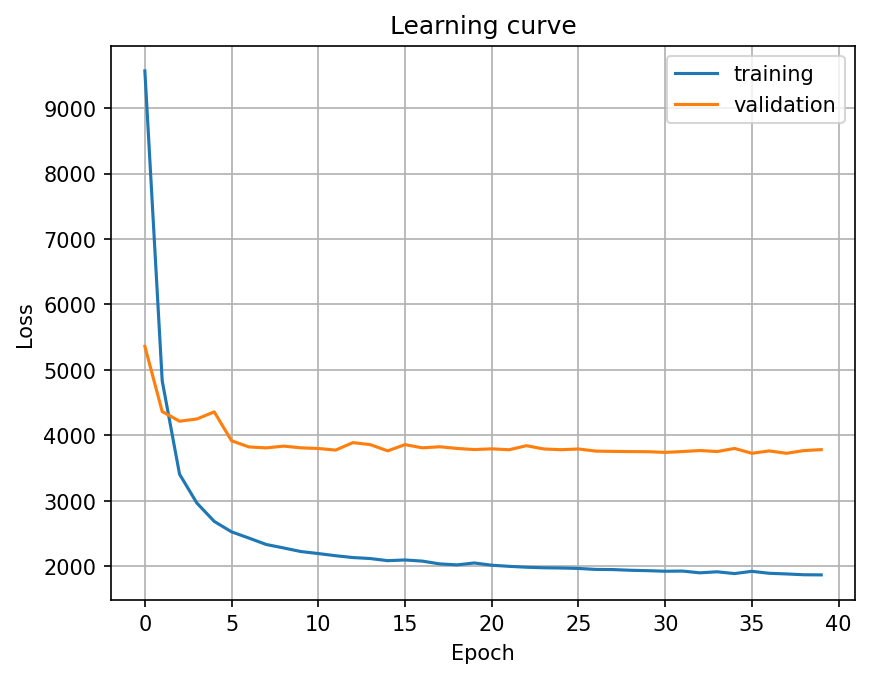

In [ ]:
plt.plot(train_losses, label="training")
plt.plot(test_losses, label="validation")
plt.title('Learning curve')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()